In [545]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import warnings
from IPython.display import Image
from sklearn.cluster import KMeans

% pylab inline

Populating the interactive namespace from numpy and matplotlib


First let's load the MTA data we ll use in this analysis. The data contain the number of swipes of each MTA card type (23 different types), for 194 weeks, for 600 Manhattan stations. 

In [6]:
data = np.load('MTA_Fare.npy')

Now let's replace all the missing values (values reported as -1) with NaN. Doing so will help us process the data in future calculations.

In [13]:
data = np.where(data !=-1, data, NaN)

We need to manipulate the data to be able to get insights out of it. First let's get the total rides by station, by card type and the total rides per week.

In [53]:
data_cardsum = np.nansum(data, axis=0) # Get the total number of rides per card type for all 194 weeks
data_cardsum.shape

(23, 194)

In [54]:
data_statsum = np.nansum(data, axis=1) # Get the total number of rides per station for all 194 weeks
data_statsum.shape

(600, 194)

In [137]:
data_weeksum = np.nansum(data_cardsum, axis=0) # Gets the total number of riders for each of the 194 weeks

Also let's develop a date index to help us match the data with its corresponding date.

In [136]:
date = pd.Index(pd.date_range(pd.to_datetime('05/28/2010'), pd.to_datetime('02/07/2014'), freq='w-FRI'))
date.shape

(194,)

Note that the sampling timeline indicated in the instructions does not correspond to 194 weeks, but 197. We are assuming that the data collection started one week after (in 05/28/2010) and lasts at 02/07/2014, exactly 194 weeks after. The reasoning for doing so is described by a characteristic extreme event we detected and managed to match its date in the data.

## Task 1: 
## Event detection, find the most prominent event in the time series

Let's plot the time series of cummulative rides per week. We also want to show the thresholds of 3 standard deviations aways from the mean. This is an indicator of an extreme event!

In [131]:
ts_mean = np.nanmean(data_weeksum/1e6) 
ts_std = np.nanstd(data_weeksum/1e6)

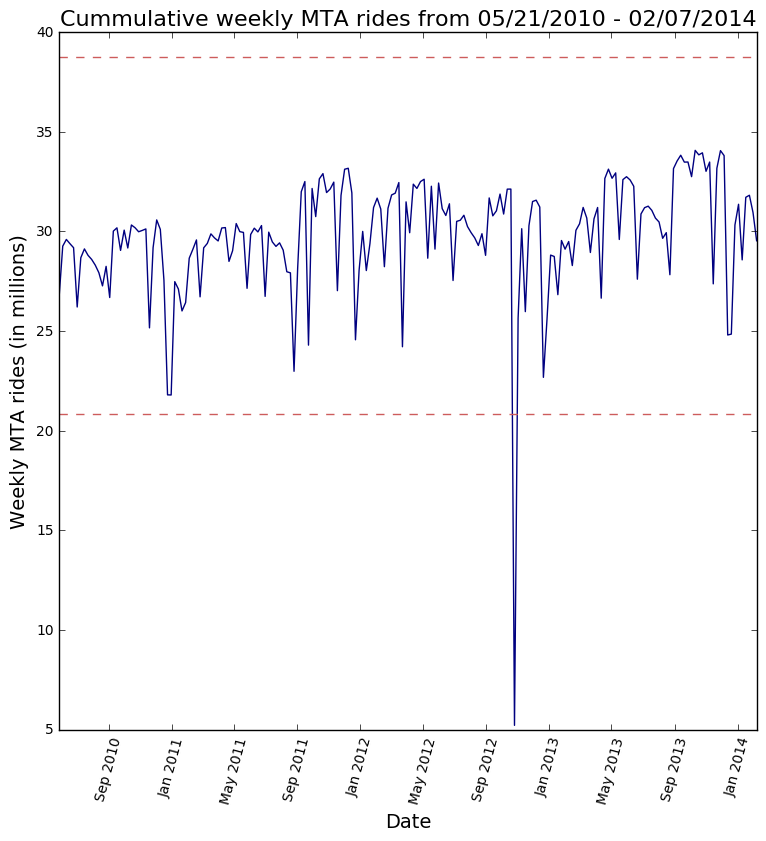

In [322]:
plt.figure(figsize=(9,9))
plt.plot(date, data_weeksum/1e6, 'navy')
plt.axhline(y=ts_mean + 3 * ts_std, linestyle='--', color='indianred')
plt.axhline(y=ts_mean - 3 * ts_std, linestyle='--', color='indianred')
plt.ylabel('Weekly MTA rides (in millions)', size=14)
plt.xlabel('Date', size=14)
plt.xticks(rotation=75)
plt.title('Cummulative weekly MTA rides from 05/21/2010 - 02/07/2014', size = 16)
plt.show()

### Figure 1
Shows the cummulative MTA rides per week (in millions) from May 2010 to February 2014. We notice some standard decreases in demand during the last week of December each year, which potentially could be attributed to the fact that is holidays and the number of daily commuters is minimal during this period of time. 

Most importantly we observe a very significant decrease (greater than 3 standard deviations from the mean, indicated by the red dashed lines) in a week of Fall 2012 that needs further investigation.

Let's isolate this time period and see the exact timing of the event.

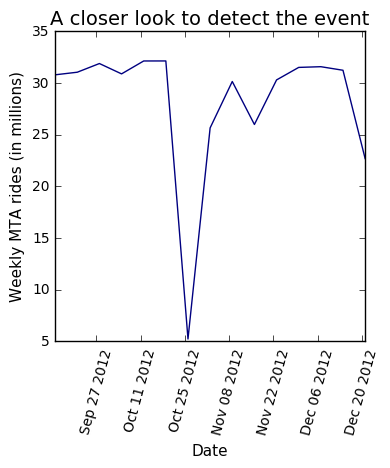

In [139]:
plt.figure(figsize=(4,4))
plt.plot(date[120:135], data_weeksum[120:135]/1e6, 'navy')
plt.ylabel('Weekly MTA rides (in millions)', size=11)
plt.xlabel('Date', size=11)
plt.xticks(rotation=75)
plt.title('A closer look to detect the event', size=14)
plt.show()

### Figure 2
Shows a closer look of __Figure 1__ in the time when the extreme event was detected. We notice that the event happened in the last week of October 2012.

Remember what happened on __October 29th 2012__ --> [Hurricane Sandy hit New York City](http://www.huffingtonpost.com/2013/10/28/sandy-anniversary_n_4170982.html). This is the reason why we observe such a huge drop in the usage of MTA services.

## Task 2: 
## Find the types of ridership that have been steadily increasing/decreasing over time.

Recall the variable __data_cardsum__ we defined previously. It is a time series of the cummulative rides per type of ridership for all 194 weeks.

Below we identify all 23 potential ridership types.

In [150]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

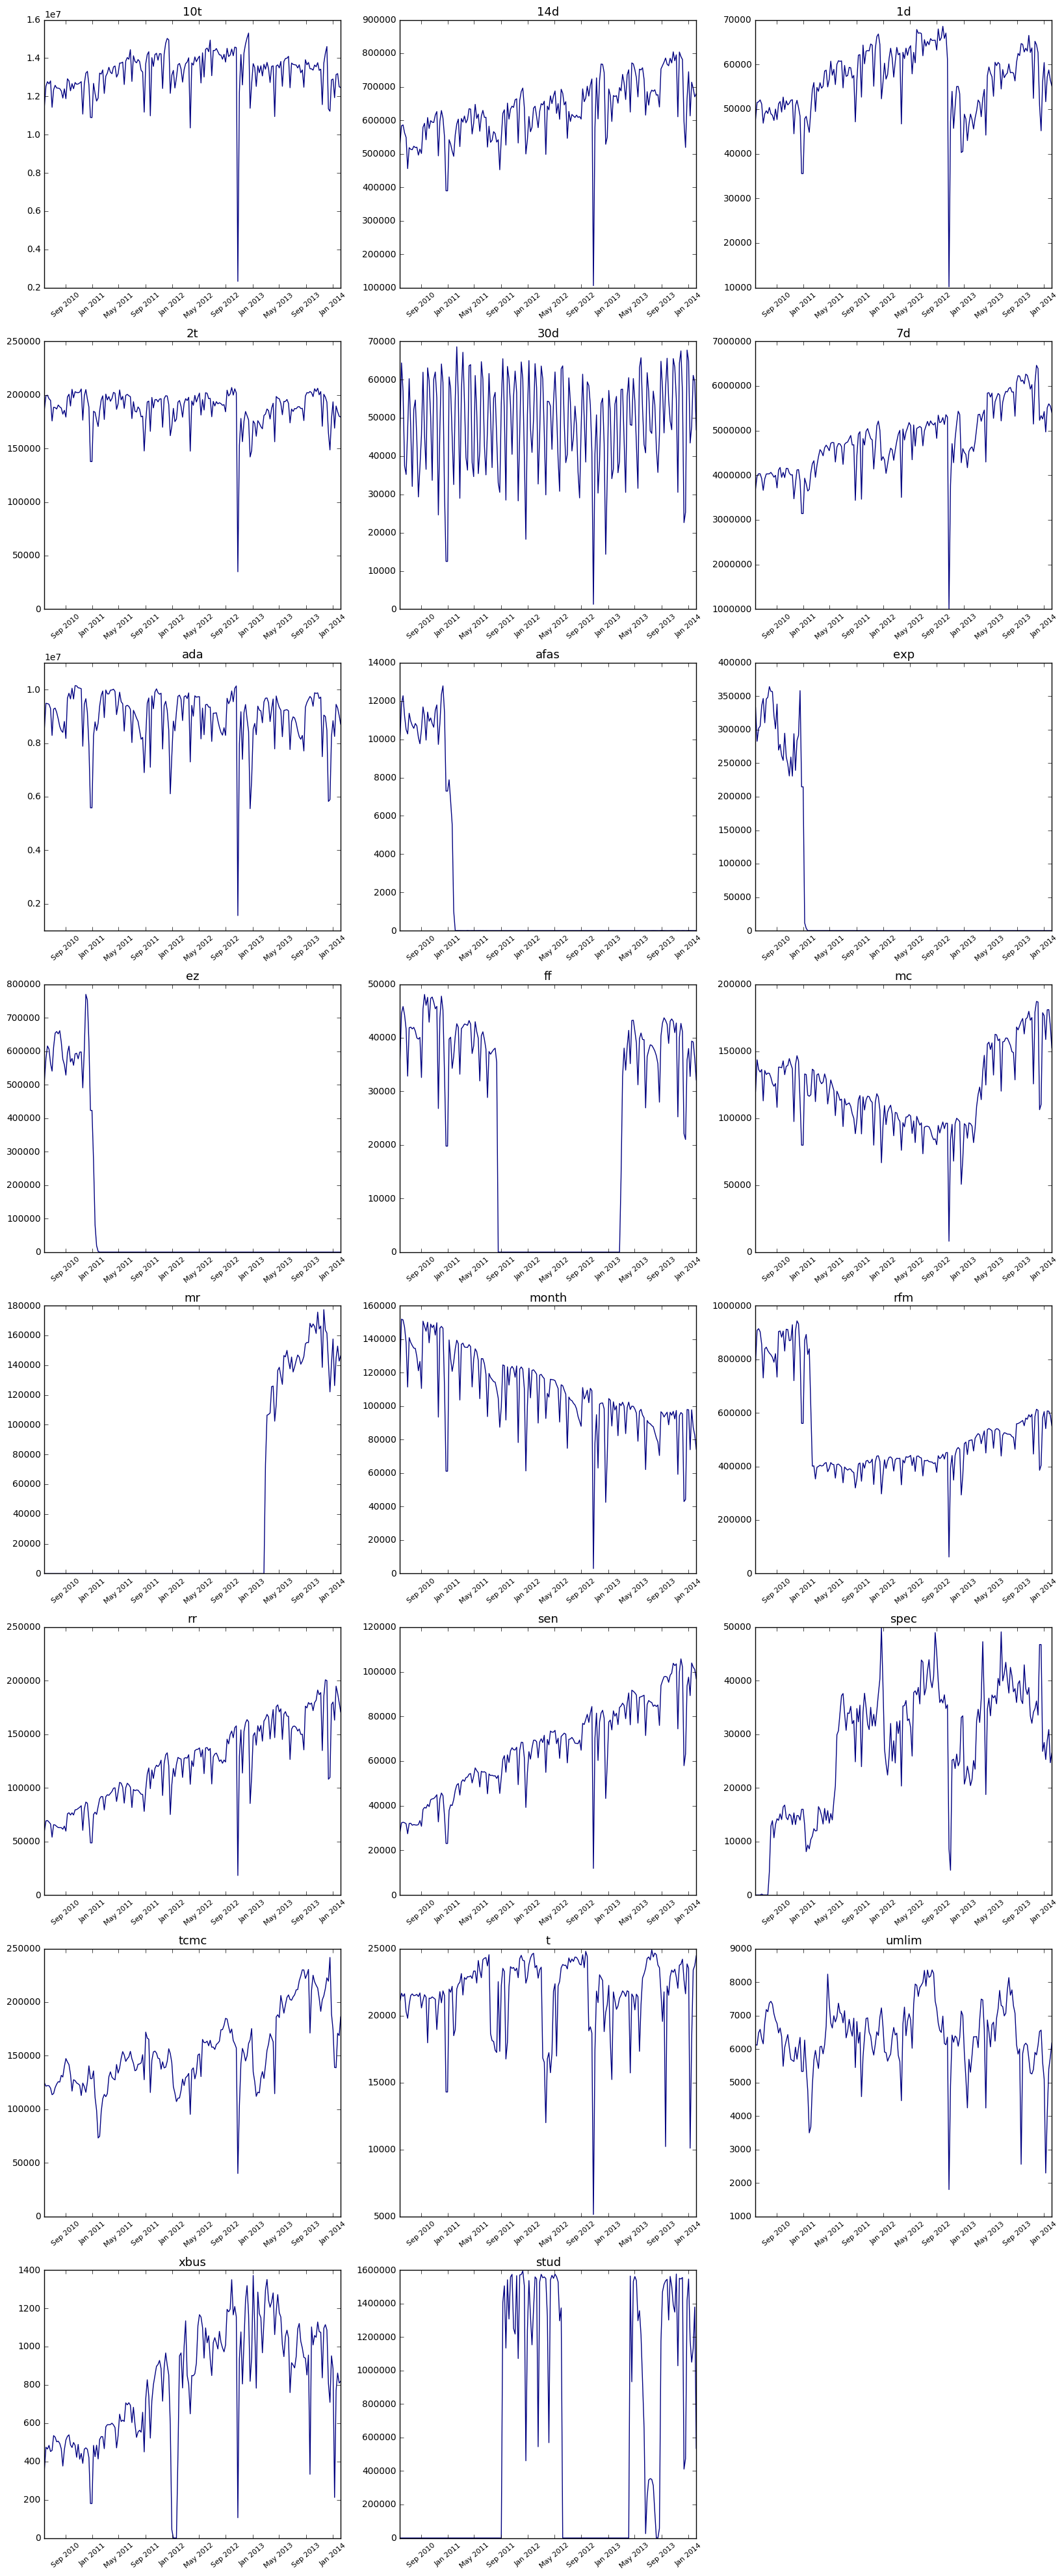

In [274]:
plt.figure(figsize=(20,50))
for i in range(0,len(ridetype)):
    plt.subplot(8,3,i+1)
    plt.plot(date,data_cardsum[i], 'navy')
    plt.xticks(rotation=40, size=8)
    plt.title(ridetype[i], size=13)

### Figure 3
Shows the cummulative number of rides per ridership type.

To get a more clear understanding of the trends in the data we are going to smooth the time series with a moving average = 10. Since we are working with numpy arrays and do not have a built-in functio to calculate the moving average, we create a function below and plot again the time series.

In [ ]:
def moving_average(series, n) :
    '''Calculates the moving average of a
    time series.
    Inputs:
    series -- the time series values
    n -- number of moving average points
    
    Returns smoothen time series'''
    
    ma = np.cumsum(series, dtype=float)
    ma[n:] = ma[n:] - ma[:-n]
    return ma[n - 1:] / n

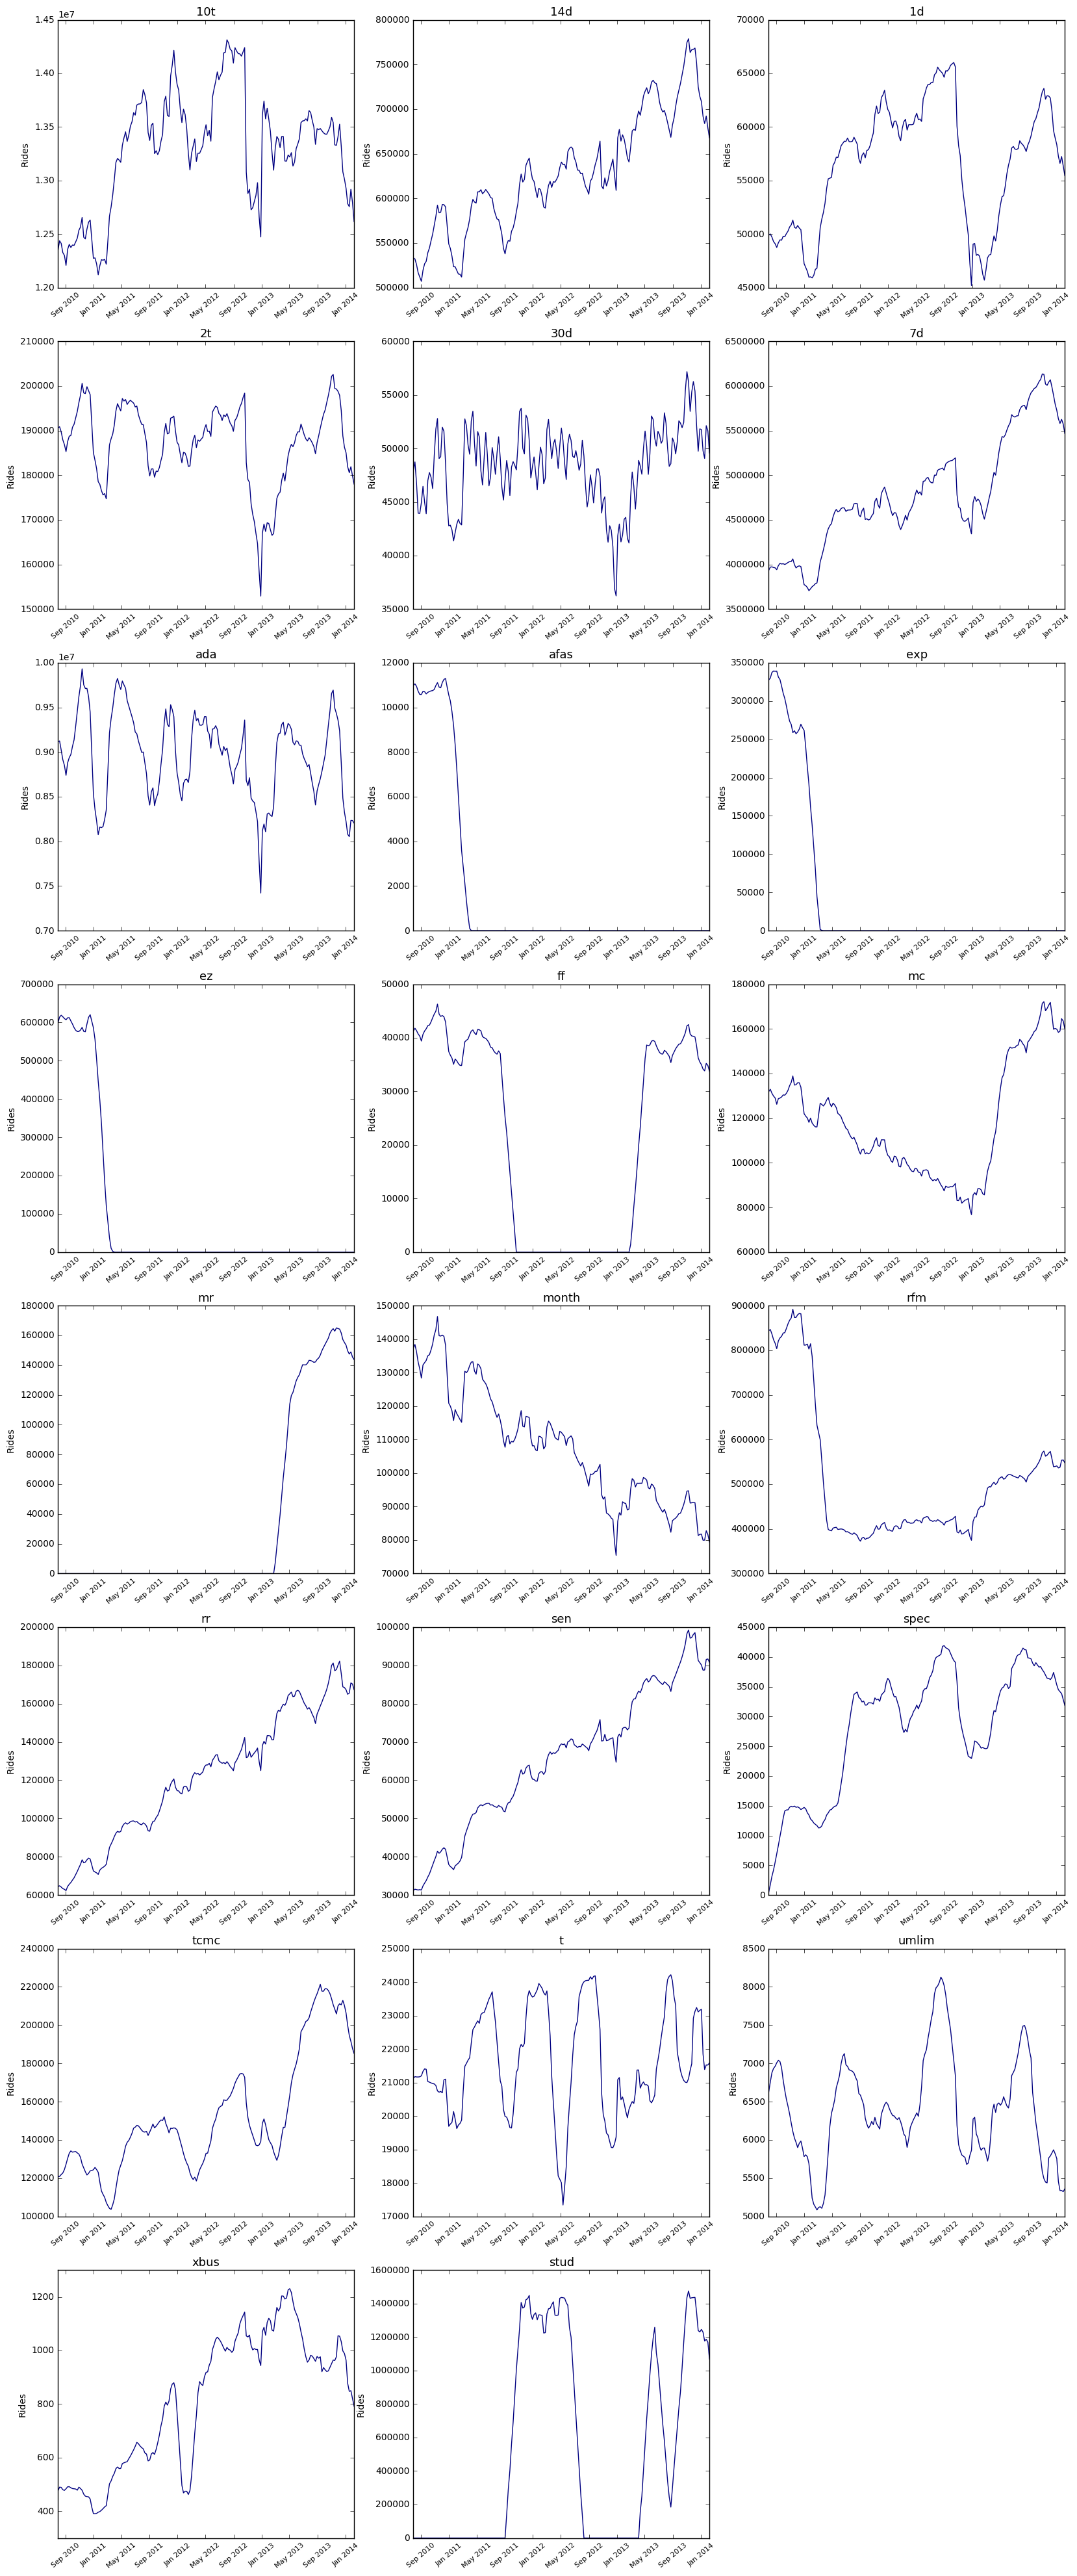

In [275]:
plt.figure(figsize=(20,50))
for i in range(0,len(ridetype)):
    plt.subplot(8,3,i+1)
    plt.plot(date[9:],moving_average(data_cardsum[i],10), 'navy')
    plt.ylabel('Rides')
    plt.xticks(rotation=40, size=8)
    plt.title(ridetype[i], size=13)

### Figure 4
Shows the time series plotted in Figure 3, with a moving average filter of 10 applied on them.

We observe an increasing trend in the following ridership types: _7 day ('7d'), 14 day ('14d'), rail road ('rr'), senior citizens ('sen')_

On the other hand, _monthly rides ('month')_ type seems to be constantly decreasing over time. 

Let's try to quantify the change in the abovementioned categories' demand. We are going to calculate the ratio of the demand during the first ten weeks over the last ten weeks.

In [246]:
day7ratio = np.nanmean(data_cardsum[5][:-11:-1])/np.nanmean(data_cardsum[5][0:10]) # Average of first 10 weeks over 10 last
day14ratio = np.nanmean(data_cardsum[1][:-11:-1])/np.nanmean(data_cardsum[1][0:10])
rr_ratio = np.nanmean(data_cardsum[15][:-11:-1])/np.nanmean(data_cardsum[15][0:10])
sen_ratio = np.nanmean(data_cardsum[16][:-11:-1])/np.nanmean(data_cardsum[16][0:10])

month_ratio = np.nanmean(data_cardsum[13][:-11:-1])/np.nanmean(data_cardsum[13][0:10])

In [519]:
print 'The average number of rides using 7-day cards in the last 10 weeks is', round(day7ratio,2),\
'times the amount of rides in the first 10 weeks.'
print 'The average number of rides using 14-day cards in the last 10 weeks is', round(day14ratio,2), \
'the amount of rides in the first 10 weeks.'
print 'The average number of rides using rail road cards in the last 10 weeks is', round(rr_ratio,2), \
'the amount of rides in the first 10 weeks.'
print 'The average number of rides using monthly cards in the last 10 weeks is', round(month_ratio,2), \
'the amount of rides in the first 10 weeks.'

The average number of rides using 7-day cards in the last 10 weeks is 1.39 times the amount of rides in the first 10 weeks.
The average number of rides using 14-day cards in the last 10 weeks is 1.25 the amount of rides in the first 10 weeks.
The average number of rides using rail road cards in the last 10 weeks is 2.59 the amount of rides in the first 10 weeks.
The average number of rides using monthly cards in the last 10 weeks is 0.58 the amount of rides in the first 10 weeks.


## Task 3: 
## Find the 4 stations with the most prominent periodicity. Figure out the reason behind the periodic peaks.

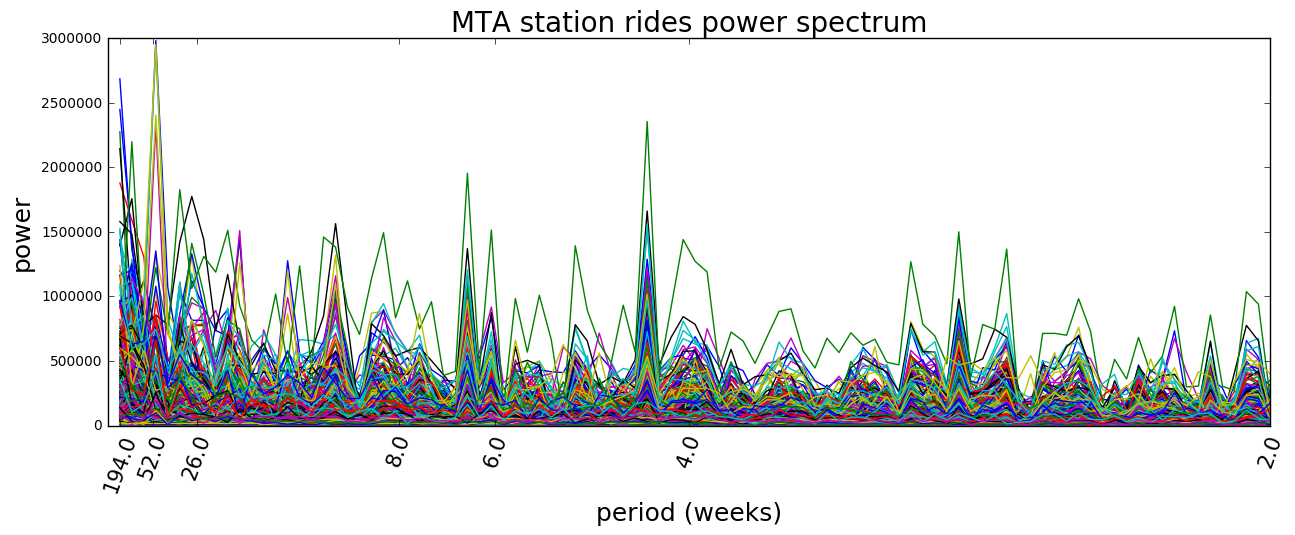

In [408]:
N = len(data_statsum[0])
x_labels = [1.0/194, 1.0/52, 1.0/26, 1.0/8, 1.0/6, 1.0/4, 1.0/2]
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
for i in range(0,len(data_statsum)):
    f = np.abs(np.fft.rfft(data_statsum[i]))
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), '-')
#x_ticks = np.append(ax.get_xticks(), x_labels)
ax.set_xticks(x_labels)
ax.set_xticklabels([ "%s"%(1.0/f) for f in x_labels], fontsize=15, rotation = 70)
#plt.axvline(x=1.0/52, color='k', linewidth = 2)
plt.xlabel("period (weeks)", fontsize=18)
plt.ylabel("power", fontsize=18)
plt.title("MTA station rides power spectrum", fontsize=20)

### Figure 5
Shows the power spectrum of each MTA station's time series. We observe few spikes in the graph, indicating a seasonal effect in the time series. Notice that the x-axis shows period (in weeks), so we can claim that there is strong annual periodicity, with a monthly periodicity following in strength.

Now we will try to find the stations with the strongest annual periodicity. To do so, we calculate the power spectrum for each station (similarly to the plot above) and find the power of the 52 weeks periodicity (1/52 frequency).

In [405]:
f_cum = np.abs(np.fft.rfft(data_statsum))

In [448]:
annual_power = []
for i in range(0,len(f_cum)):
    tmp = f_cum[i][4]
    annual_power.append(tmp)

Now what's left to do it to tranform the list into a dataframe, so we can sort it and keep the index inplace. This way we can identify the 4 stations with the most prominent annual periodicity.

In [476]:
power_df = pd.DataFrame(annual_power, columns=['AnnualPower'])

In [482]:
power_df.sort_values(by=['AnnualPower'],inplace = True)
power_df.tail()

,AnnualPower
32,2.329897e+06
327,2.402219e+06
150,2.931896e+06
194,2.950389e+06
0,2.980161e+06


We observe that stations __0, 194, 150, and 327__ are the ones demonstrating the highest annual periodicity. To understand the pattern of the periodicity and try to explain why it occurs, following we will plot the time series for each one of the 4 stations.

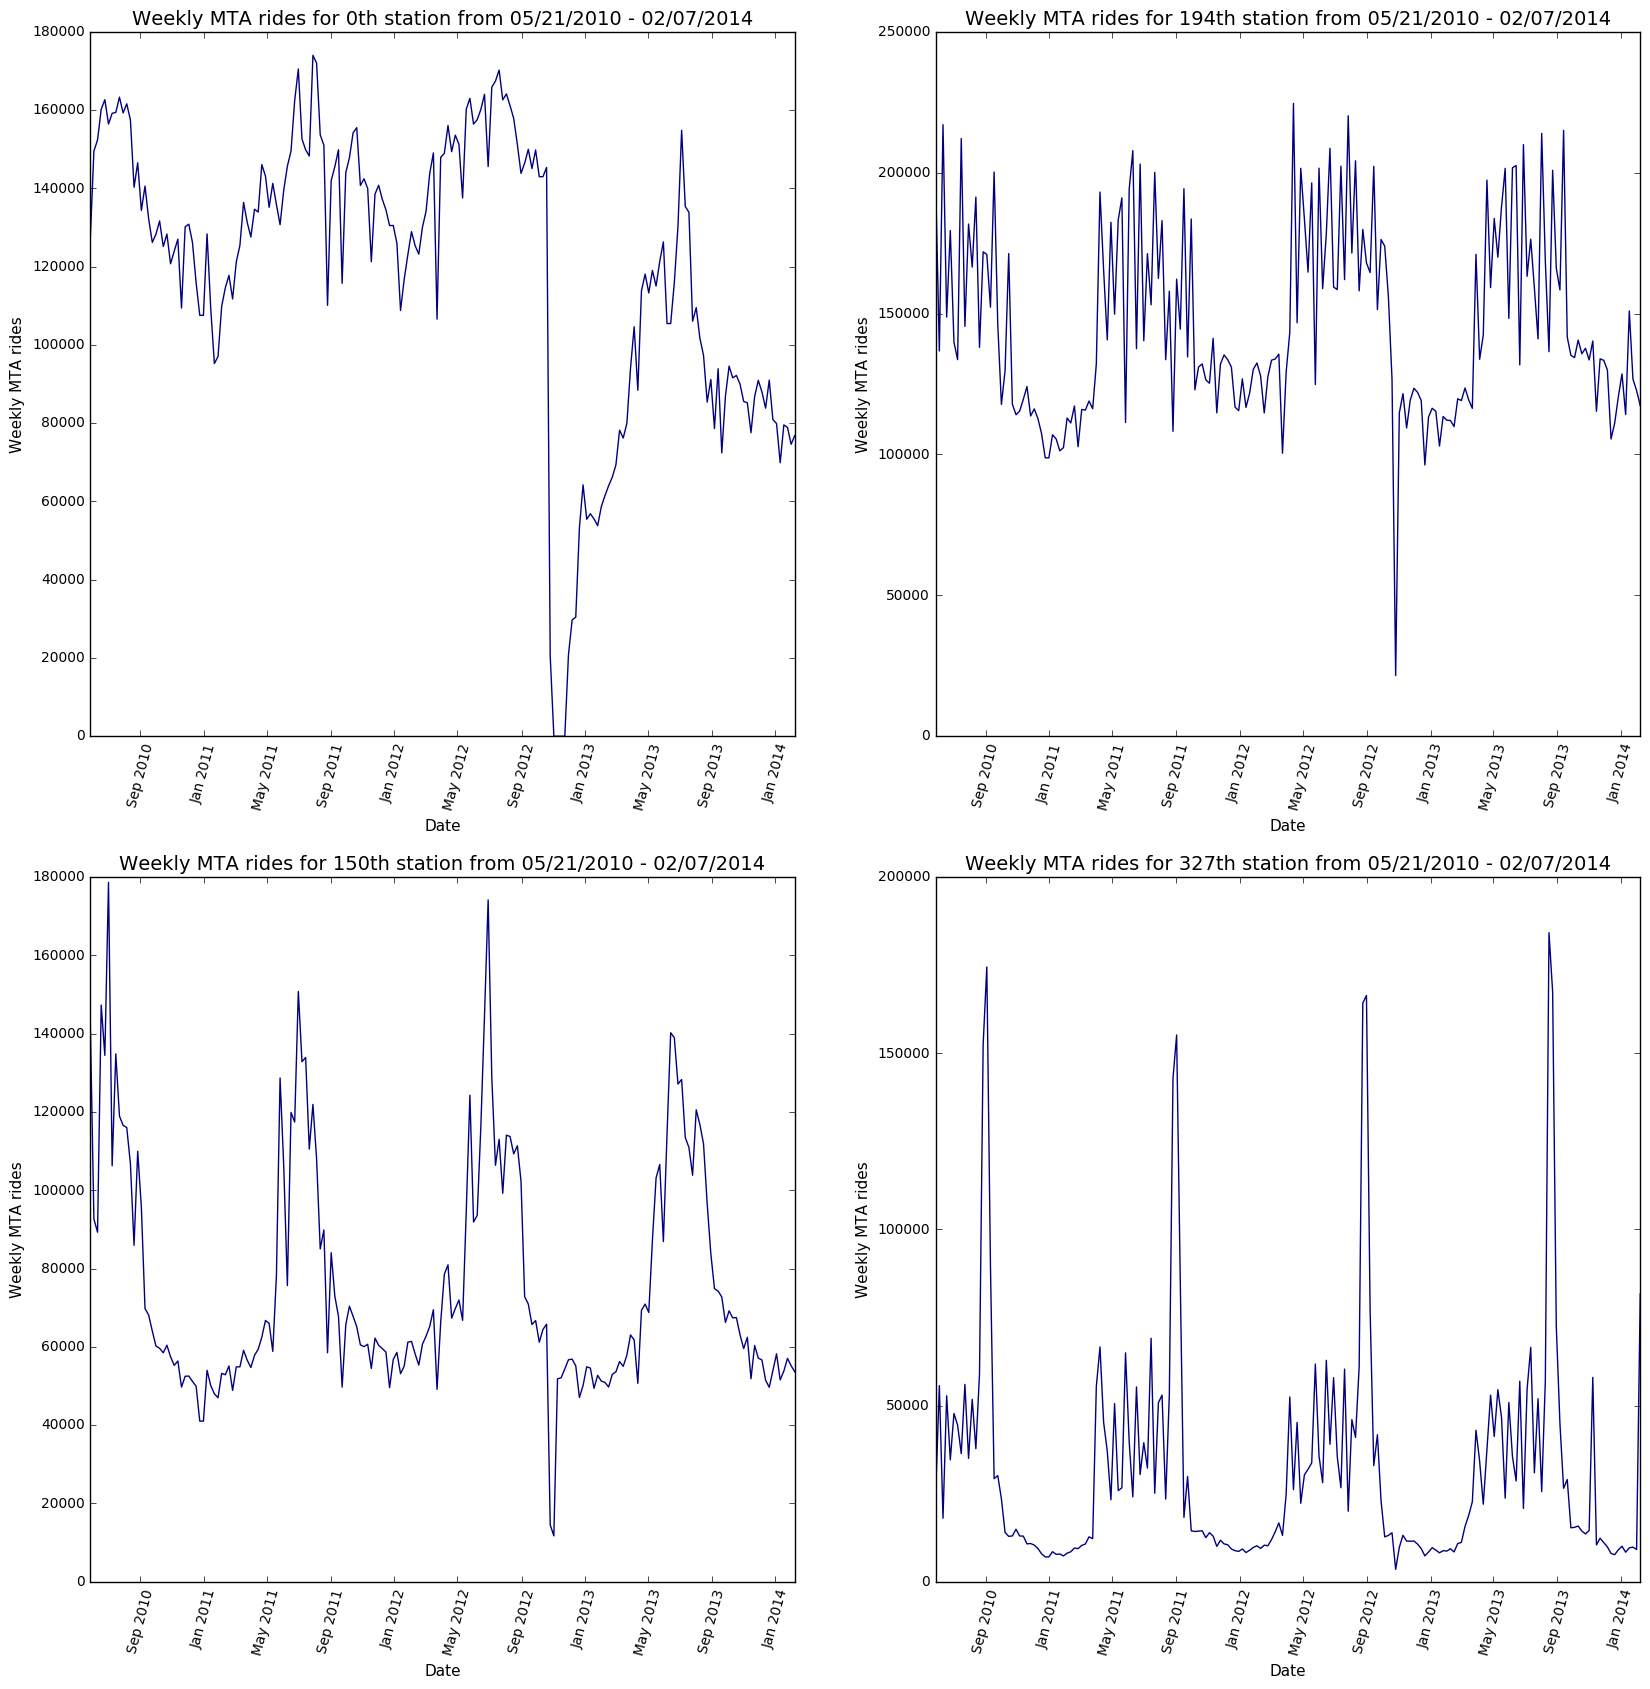

In [507]:
plt.figure(figsize=(20,20))
for i,stat in enumerate([0, 194, 150, 327]):
    plt.subplot(2,2,i+1)
    plt.plot(date, data_statsum[stat], 'navy')
    plt.ylabel('Weekly MTA rides', size=11)
    plt.xlabel('Date', size=11)
    plt.xticks(rotation=75)
    plt.title(('Weekly MTA rides for %sth station from 05/21/2010 - 02/07/2014'%stat), size = 14)

### Figure 6
Shows the time series for the stations demonstrated the highest annual periodicity. We can see that the number of weekly rides picks in September each year and reaches its lower levels on January. 

The finding makes sense from various aspects. First, September is a month that there is increased mobility in the city. Employees move here for new job opportunities, schools start, people return from vacation, tourists are visiting the city etc. On the other hand, in winter the weather is bad causing disruptions and poor customer experience. Also, most people would prefer a cozy taxi ride rather than a cold train seat during this time of the year. As Spring kicks in, we observe again an increase in train rides.

## Extra Credit: 
## Cluster the time series. Identify groups that look similar to each other.

In [508]:
# tots = data.transpose(2,0,1).reshape(data.shape[2], data.shape[1]*data.shape[0]).T
# tots = tots[tots.std(1)>0]
# tots.mean(1)
# vals = ((tots.T - tots.mean(1))/tots.std(1)).T
# kmeans = KMeans(n_clusters=10, random_state=21).fit(vals)
# kmeans.labels_

What we are going to do in this part is to use a clustering algorithm, aiming to identify time series sharing similar properties. 

We will use the types of ridership time series from _Task 2_ and train a KMeans model to cluster them based on their overall trend, i.e. increasing, decreasing, constant.

First, let's standardize our data by subtracting the mean and dividing by the standard deviation. Doing so enables us to bring its time series down to the same scale.

In [554]:
data_cardsum.mean(1)
vals = ((data_cardsum.T - data_cardsum.mean(1))/data_cardsum.std(1)).T

Now that the data are standardized, we fit a KMeans model with 3 clusters.

In [567]:
kmeans = KMeans(n_clusters=3, random_state=21).fit(vals)
k_labels = kmeans.labels_
k_labels

array([1, 2, 1, 1, 1, 2, 1, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 1, 1, 2, 2], dtype=int32)

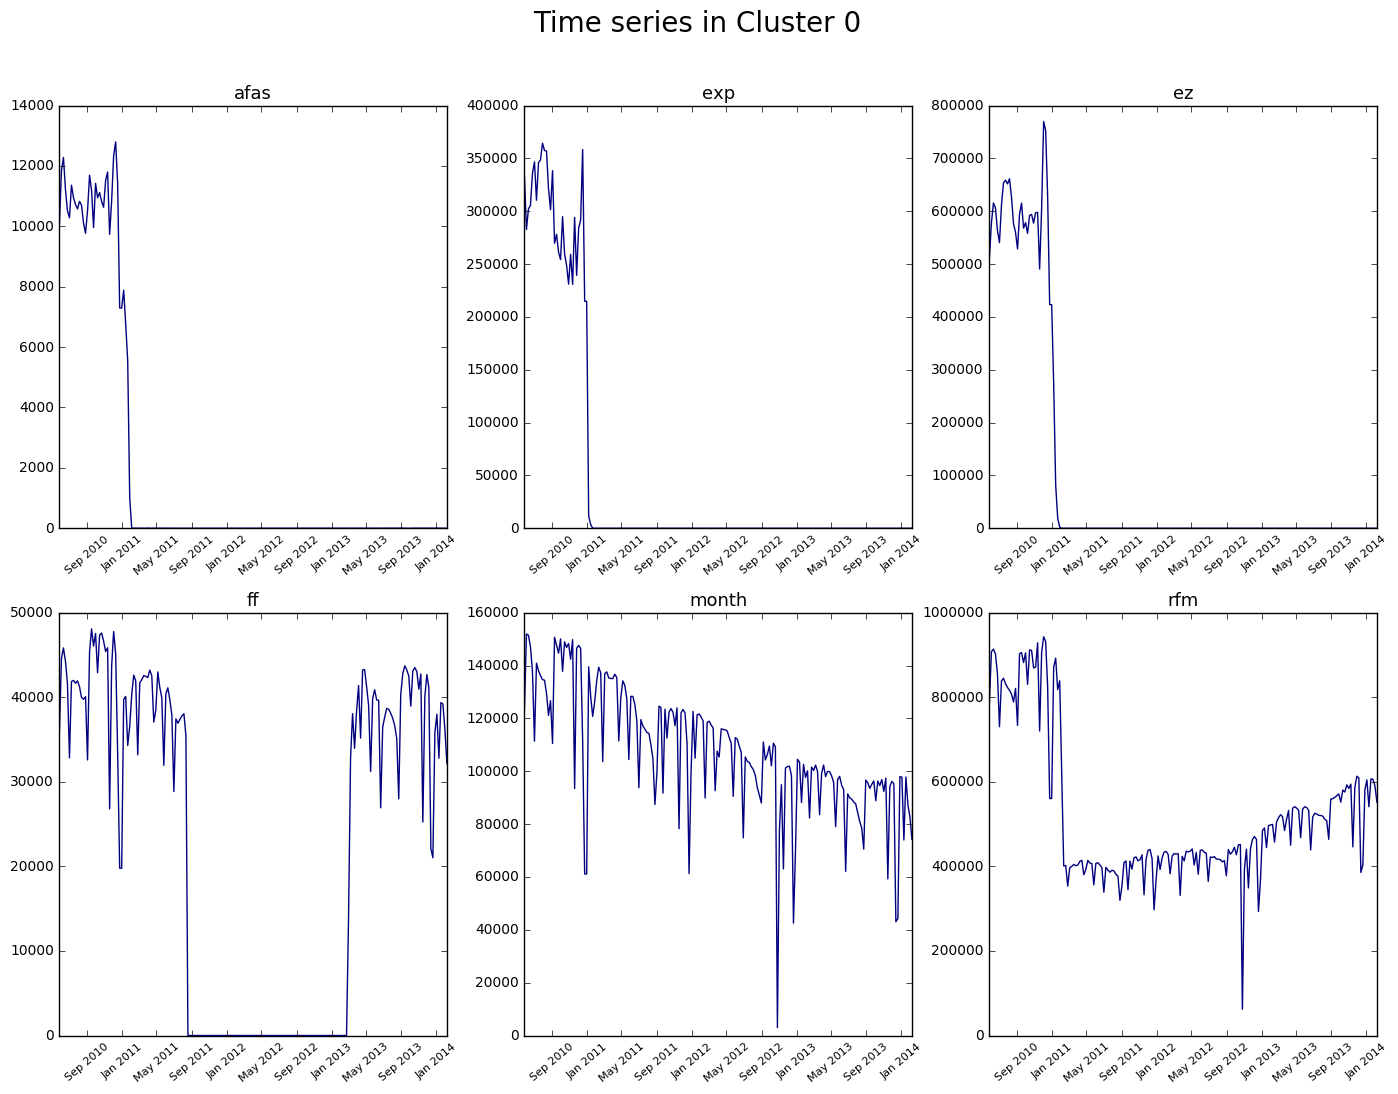

In [569]:
count = 1
plt.figure(figsize=(17,12))
plt.suptitle('Time series in Cluster 0', size = 20)
for i in range(0,len(ridetype)):
    if k_labels[i]==0:
        plt.subplot(2,3,count)
        plt.plot(date,data_cardsum[i], 'navy')
        plt.xticks(rotation=40, size=8)
        plt.title(ridetype[i], size=13)
        count = count+1

### Figure 7
Shows the times series belonging to the first cluster (_Cluster 0_). All of them have a decreasing trend over time.

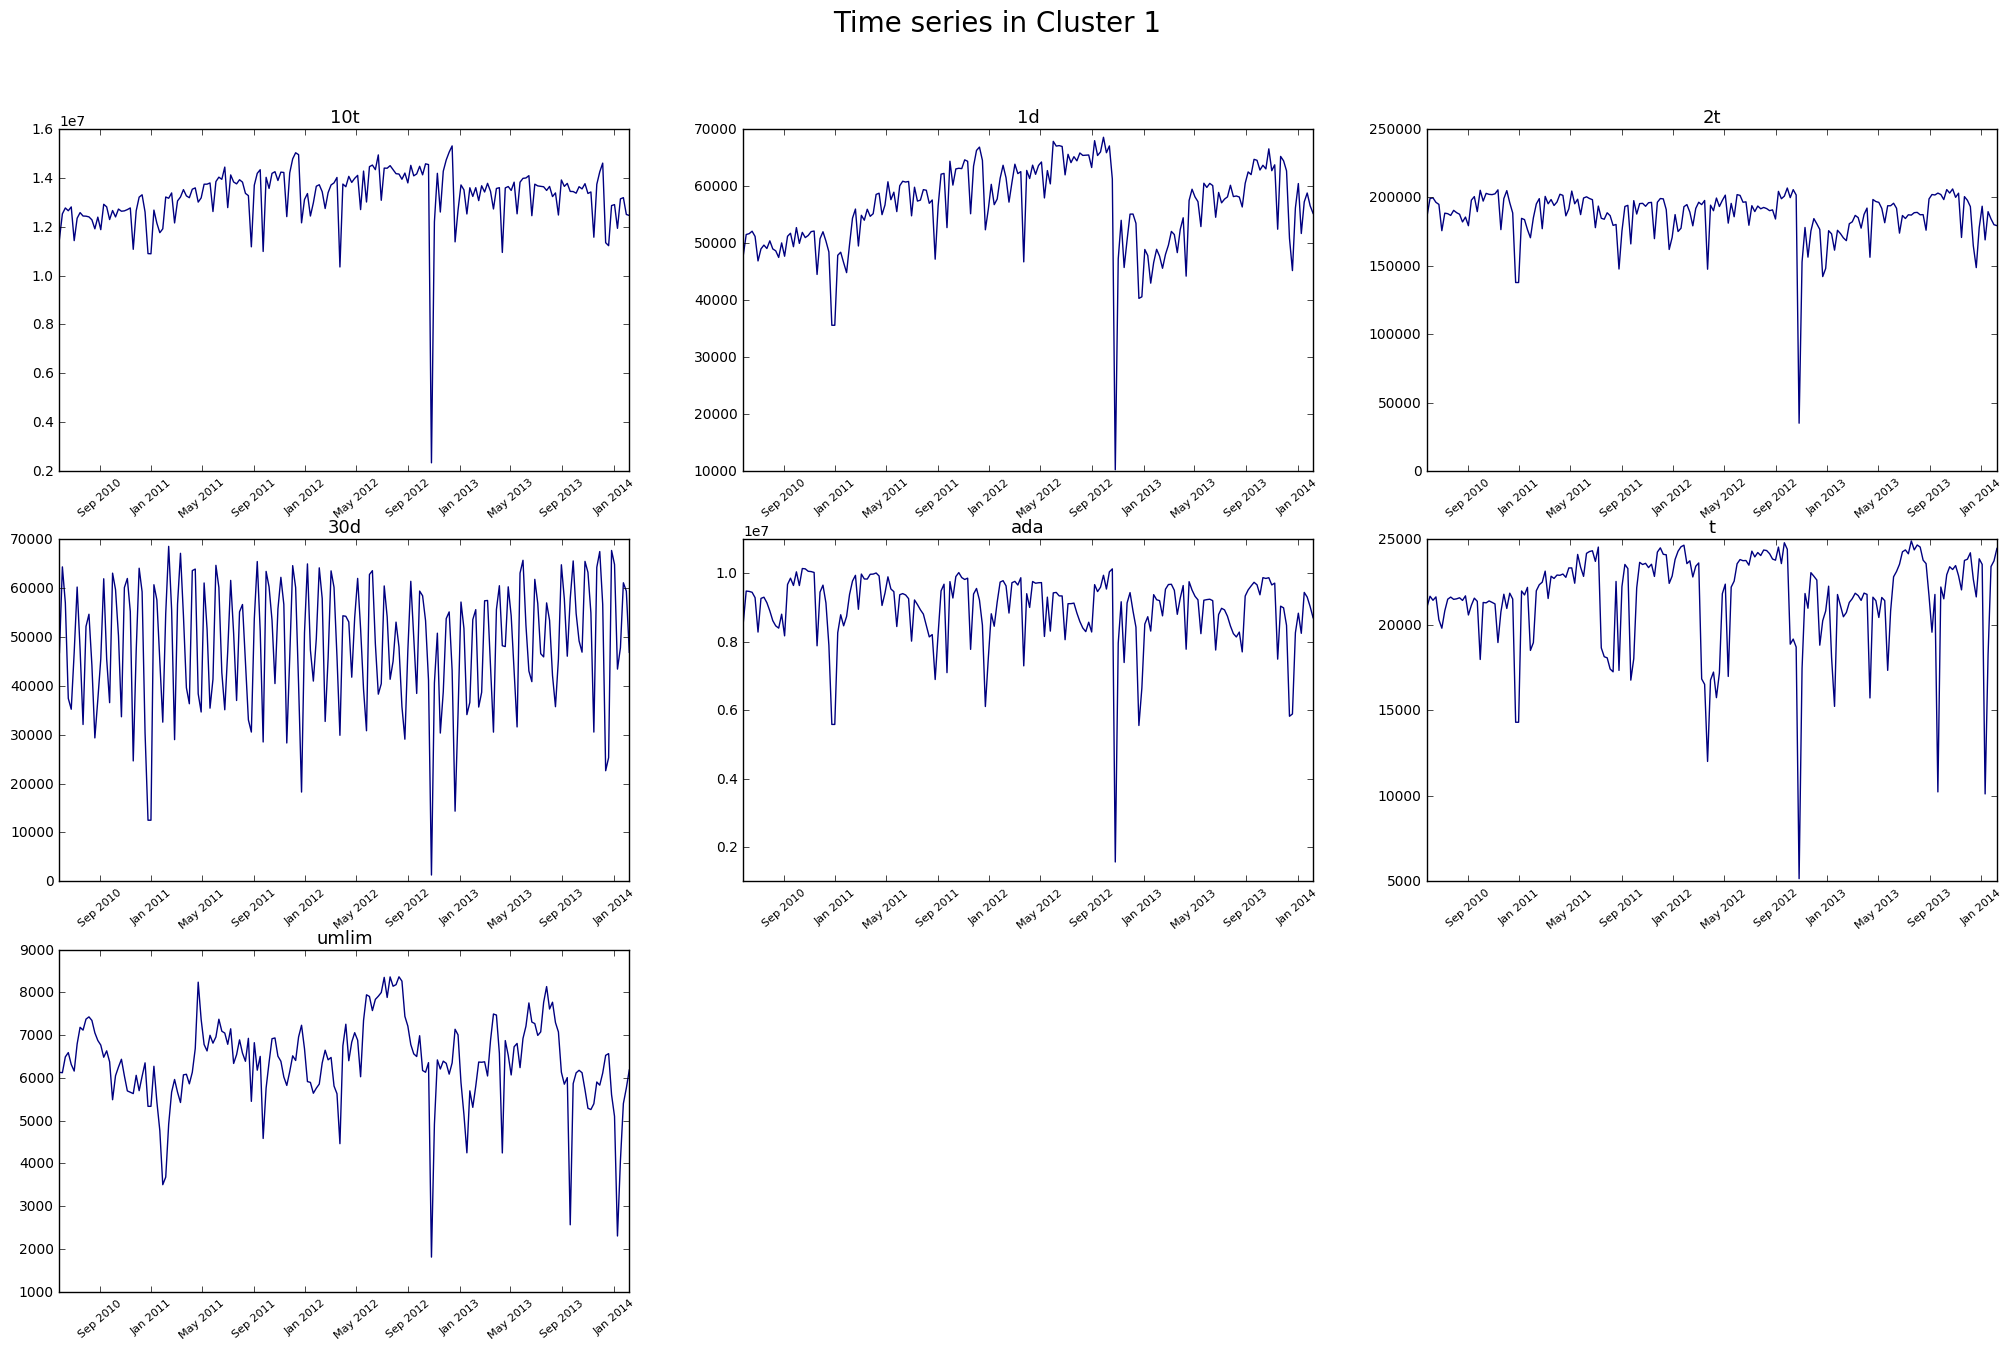

In [570]:
count = 1
plt.figure(figsize=(25,15))
plt.suptitle('Time series in Cluster 1', size = 20)
for i in range(0,len(ridetype)):
    if k_labels[i]==1:
        plt.subplot(3,3,count)
        plt.plot(date,data_cardsum[i], 'navy')
        plt.xticks(rotation=40, size=8)
        plt.title(ridetype[i], size=13)
        count = count+1

### Figure 8
Shows the times series belonging to the second cluster (_Cluster 1_). In general, the number of rides seems constant in all this types of ridership.

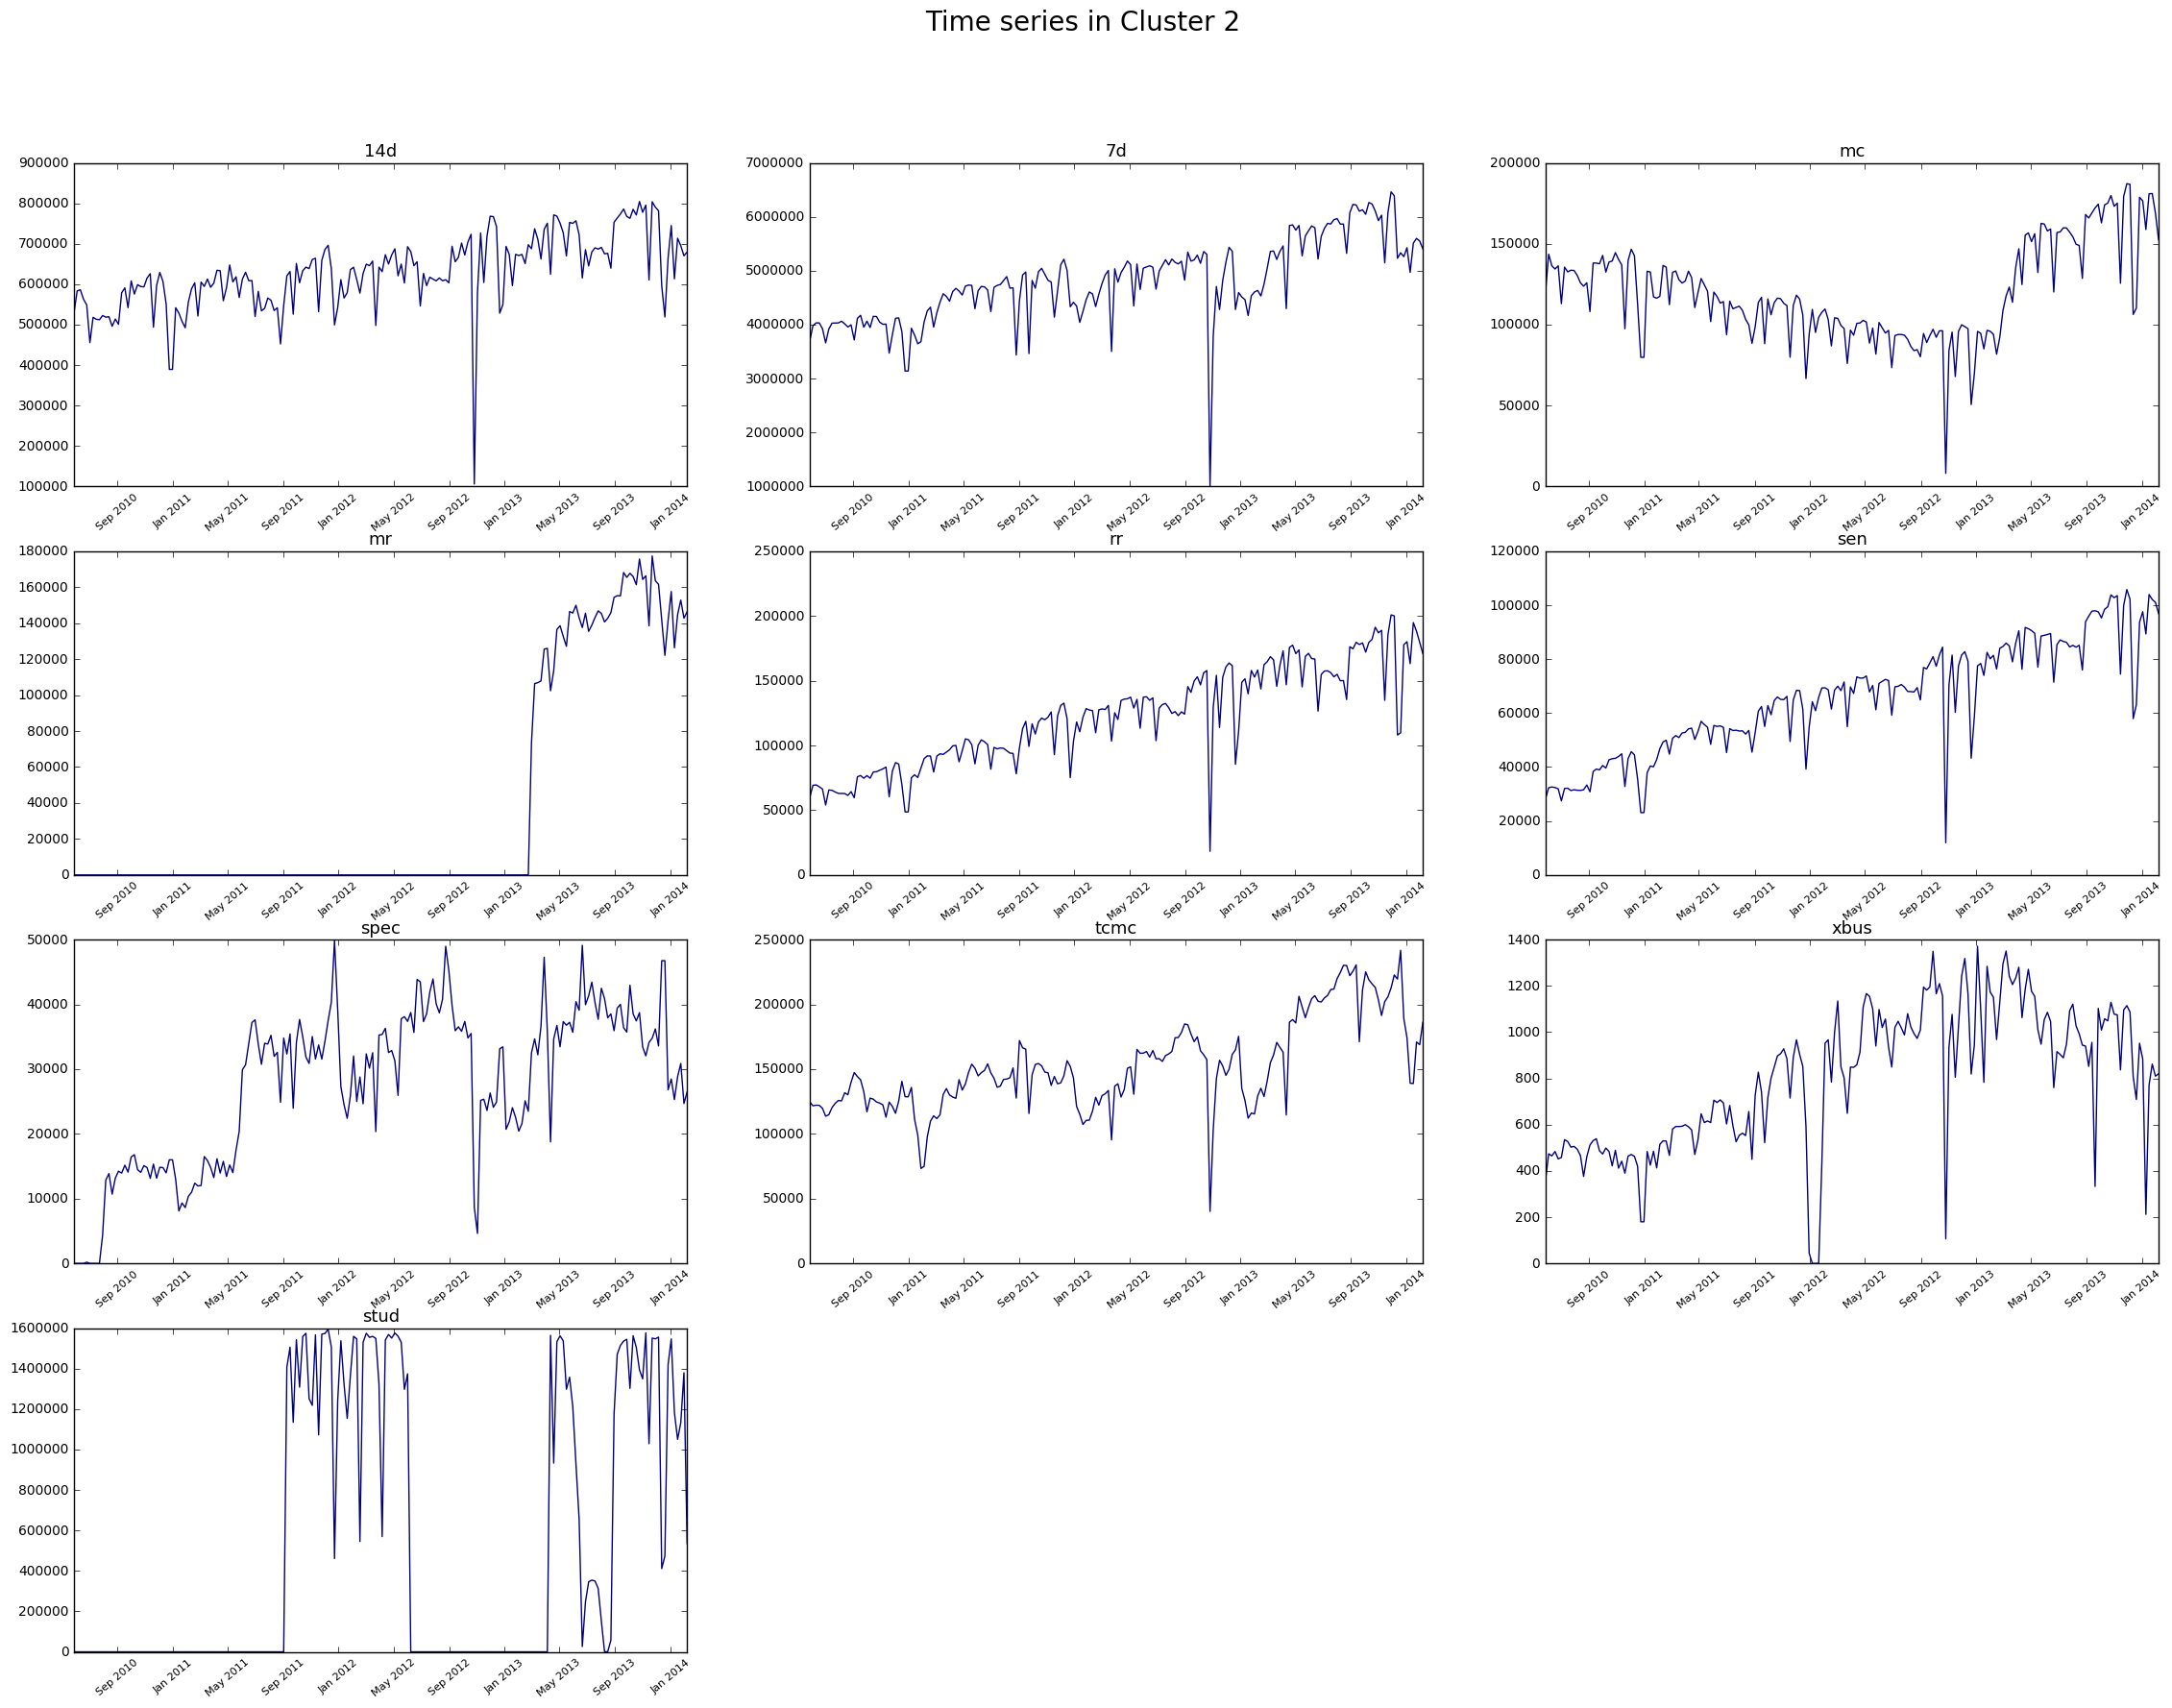

In [571]:
count = 1
plt.figure(figsize=(28,20))
plt.suptitle('Time series in Cluster 2', size = 20)
for i in range(0,len(ridetype)):
    if k_labels[i]==2:
        plt.subplot(4,3,count)
        plt.plot(date,data_cardsum[i], 'navy')
        plt.xticks(rotation=40, size=8)
        plt.title(ridetype[i], size=13)
        count = count+1

### Figure 9
Shows the times series belonging to the third cluster (_Cluster 2_). We can observe an increasing demand pattern on the types of ridership in this cluster.

In general, KMeans seems to work pretty well, clustering correctly in most cases the time series with similar trends.